
<a id='egm-policy-iter'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Crescimento Ótimo III: O Método do *Grid* Endógeno

## Conteúdo

- [Crescimento Ótimo III: O Método do Grid Endógeno](#Crescimento-Ótimo-III:-O-Método-do-Grid-Endógeno)  
  - [Resumo](#Resumo)  
  - [A Idéia Chave](#A-Idéia-Chave)  
  - [Implementação](#Implementação)  
  - [Velocidade](#Velocidade)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Resolvemos o modelo estocástico de crescimento ótimo usando:

1. [A função de valor iteração](https://julia.quantecon.org/optgrowth.html).  
1. [A equação de Euler baseada nas iterações de tempo](https://julia.quantecon.org/coleman_policy_iter.html).  


Descobrimos que a iteração de tempo é significativamente mais precisa a cada etapa.

Nesta aula, veremos uma reviravolta engenhosa na técnica de iteração no tempo chamada **método do *grid* endógeno** (EGM).

EGM é um método numérico para implementar a iteração de políticas, inventada por [Chris Carroll](http://www.econ2.jhu.edu/people/ccarroll/).

É um bom exemplo de como um algoritmo inteligente pode economizar uma quantidade enorme de tempo no computador.

(Massivo quando multiplicamos os ciclos de CPU salvos em cada implementação vezes o número de implementações em todo o mundo)

A referência original é [[Car06]](https://julia.quantecon.org/../zreferences.html#carroll2006).

## A Idéia Chave

Vamos começar lembrando a teoria e depois ver como os números se encaixam.

### Teoria

Pegue o modelo estabelecido na [aula de iteração de tempo](https://julia.quantecon.org/coleman_policy_iter.html), seguindo a mesma terminologia e notação.

A equação de Euler é:


<a id='equation-egm-euler'></a>
$$
(u'\circ c^*)(y)
= \beta \int (u'\circ c^*)(f(y - c^*(y)) z) f'(y - c^*(y)) z \phi(dz) \tag{1}
$$

Como vimos, o operador Coleman é um operador não linear $ K $ projetado para que $ c^* $ seja um ponto fixo de $ K $.

Tomando como seu argumento uma política de consumo estritamente crescente e contínua $ g \in \Sigma $.

Isso retorna uma nova função $ Kg $, onde $ (Kg)(y) $ é o $ c \in (0, \infty) $ que resolve:


<a id='equation-egm-coledef'></a>
$$
u'(c)
= \beta \int (u' \circ g) (f(y - c) z ) f'(y - c) z \phi(dz) \tag{2}
$$

### *Grid* Exógeno

Conforme discutido na [aula de iteração de tempo](https://julia.quantecon.org/coleman_policy_iter.html), para implementar o método em um computador, precisamos da aproximação numérica.

Em particular, representamos uma função de política por um conjunto de valores em um *grid* finito.

A função em si é reconstruída a partir dessa representação quando necessário, usando interpolação ou algum outro método.

[Anteriormente](https://julia.quantecon.org/coleman_policy_iter.html), para obtermos uma representação finita de uma política de consumo atualizada faziamos,

- fixavamos um *grid* de pontos de renda $ \{y_i\} $  
- calculavamos o valor do consumo $ c_i $ correspondente para cada
  $ y_i $ usando [(2)](#equation-egm-coledef) e uma rotina de localização de raiz.


Cada $ c_i $ é então interpretada como o valor da função $ K g $ em $ y_i $.

Então, com os pontos $ \{y_i, c_i\} $ em mãos, podemos reconstruir $ Kg $ via aproximação.

A iteração então continua…

### *Grid* Endógeno

O método discutido acima requer uma rotina de localização de raiz para encontrar o
$ c_i $ correspondente a um dado valor de renda $ y_i $.

A localização da raiz é custosa, pois geralmente envolve um número significativo de avaliações de funções.

Conforme apontado por [[Car06]](https://julia.quantecon.org/../zreferences.html#carroll2006), podemos evitar isso se 
$ y_i $ for escolhido endogenamente.

A única suposição requerida é que $ u' $ é invertível em $ (0, \infty) $.

A idéia é essa:

Primeiro fixamos um *grid* exógeno $ \{k_i\} $ para capital ($ k = y - c $).

Então obtemos $ c_i $ via:


<a id='equation-egm-getc'></a>
$$
c_i =
(u')^{-1}
\left\{
    \beta \int (u' \circ g) (f(k_i) z ) \, f'(k_i) \, z \, \phi(dz)
\right\} \tag{3}
$$

onde $ (u')^{-1} $ é a função inversa de $ u' $.

Finalmente, para cada $ c_i $ definimos $ y_i = c_i + k_i $.

É claro que cada par construído $ (y_i, c_i) $ dessa maneira satisfaz [(2)](#equation-egm-coledef).

Com os pontos $ \{y_i, c_i\} $ em mãos, podemos reconstruir $ Kg $ por aproximação como antes.

O nome EGM vem do fato de que o *grid* $ \{y_i\} $ é **endogenamente** determinado.

## Implementação

Vamos implementar esta versão do operador Coleman e ver como ele funciona.

### O Operador

Aqui está uma implementação de $ K $ usando EGM como descrito acima.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Random, Roots
gr(fmt = :png);

In [3]:
function coleman_egm(g, k_grid, β, u′, u′_inv, f, f′, shocks)

    # Aloca memória para o valor do consumo em pontos do grid endógenos 
    c = similar(k_grid)

    # Resolve para o valor do consumo atualizado
    for (i, k) in enumerate(k_grid)
        vals = u′.(g.(f(k) * shocks)) .* f′(k) .* shocks
        c[i] = u′_inv(β * mean(vals))
    end

    # Determina endogenamente o grid
    y = k_grid + c  # y_i = k_i + c_i

    # Atualiza a função de política e retorna
    Kg = LinearInterpolation(y,c, extrapolation_bc=Line())
    Kg_f(x) = Kg(x)
    return Kg_f
end

coleman_egm (generic function with 1 method)

Observe a falta de qualquer algoritmo de localização raiz.

Também executaremos nossa implementação original, que usa um *grid* exógeno e requer descoberta de raiz, para que possamos realizar algumas comparações.

In [4]:
function K!(Kg, g, grid, β, u′, f, f′, shocks)

    # Esta função requer o contêiner do valor do produto como argumento Kg

    # Constroi um objeto de interpolação linear 
    g_func = LinearInterpolation(grid, g, extrapolation_bc = Line())

    # Resolve para o valor de consumo atualizado #
    for (i, y) in enumerate(grid)
        function h(c)
            vals = u′.(g_func.(f(y - c) * shocks)) .* f′(y - c) .* shocks
            return u′(c) - β * mean(vals)
        end
        Kg[i] = find_zero(h, (1e-10, y - 1e-10))
    end
    return Kg
end

# A função a seguir NÃO requer o contêiner do valor do produto como argumento 
K(g, grid, β, u′, f, f′, shocks) =
    K!(similar(g), g, grid, β, u′, f, f′, shocks)

K (generic function with 1 method)

Vamos testar o código acima em alguns exemplos de parametrizações, após as seguintes importações.

### Testando no Caso Log / Cobb–Douglas

Como fizemos [para a função de valor iteração](https://julia.quantecon.org/optgrowth.html) e [iteração no tempo](https://julia.quantecon.org/coleman_policy_iter.html), vamos começar testando nosso método com o benchmark log-linear .

O primeiro passo é trazer o modelo que usamos na [iteração da função da política de Coleman](https://julia.quantecon.org/coleman_policy_iter.html).

In [5]:
# O modelo

Model = @with_kw (α = 0.65, # parâmetro de produtividade
                  β = 0.95, # fator de desconto
                  γ = 1.0,  # aversão ao risco
                  μ = 0.0,  # lognorm(μ, σ)
                  s = 0.1,  # lognorm(μ, σ)
                  grid_min = 1e-6, # menor ponto do grid
                  grid_max = 4.0,  # maior ponto do grid
                  grid_size = 200, # tamanho do grid
                  u = γ == 1 ? log : c->(c^(1-γ)-1)/(1-γ), # função utilidade
                  u′ = c-> c^(-γ), # u'
                  f = k-> k^α, # função de produção
                  f′ = k -> α*k^(α-1), # f'
                  grid = range(grid_min, grid_max, length = grid_size)) # grid

#5 (generic function with 2 methods)

Em seguida, geramos uma instância.

In [6]:
mlog = Model(); # modelo Log Linear 

Também precisamos de alguns choques para a integração de Monte Carlo.

In [7]:
Random.seed!(42); # Para comportamento reproduzível.

shock_size = 250     # Número de choques na integração de Monte Carlo
shocks = exp.(mlog.μ .+ mlog.s * randn(shock_size));

Como teste preliminar, vamos ver se $ K c^* = c^* $, como está implícito na teoria.

In [8]:
c_star(y) = (1 - mlog.α * mlog.β) * y

# algumas constantes usuais
ab = mlog.α * mlog.β
c1 = log(1 - ab) / (1 - mlog.β)
c2 = (mlog.μ + mlog.α * log(ab)) / (1 - mlog.α)
c3 = 1 / (1 - mlog.β)
c4 = 1 / (1 - ab)

v_star(y) = c1 + c2 * (c3 - c4) + c4 * log(y)

v_star (generic function with 1 method)

In [9]:
function verify_true_policy(m, shocks, c_star)
    k_grid = m.grid
    c_star_new = coleman_egm(c_star, k_grid, m.β, m.u′, m.u′, m.f, m.f′, shocks)

    plt = plot()
    plot!(plt, k_grid, c_star.(k_grid), lw = 2, label = "optimal policy c*")
    plot!(plt, k_grid, c_star_new.(k_grid), lw = 2, label = "Kc*")
    plot!(plt, legend = :topleft)
end

verify_true_policy (generic function with 1 method)

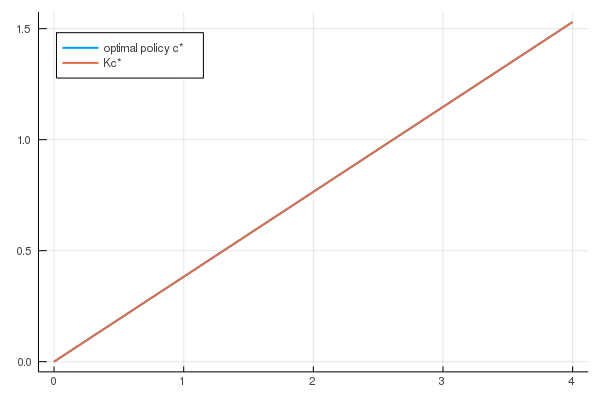

In [10]:
verify_true_policy(mlog, shocks, c_star)

Perceba que estamos passando u′ para coleman_egm duas vezes.

A razão é que, no caso da utilidade log, $ u'(c) = (u')^{-1}(c) = 1/c $.

Portanto u′ e u′_inv são os mesmos.

Não podemos realmente distinguir as duas parcelas.

De fato, é fácil ver que a diferença é essencialmente zero:

In [11]:
c_star_new = coleman_egm(c_star, mlog.grid, mlog.β, mlog.u′,
                         mlog.u′, mlog.f, mlog.f′, shocks)
maximum(abs(c_star_new(g) - c_star(g)) for g in mlog.grid)

1.3322676295501878e-15

Em seguida, vamos tentar iterar a partir de uma condição inicial arbitrária e ver se convergimos para $ c^* $.

Vamos começar com a política de consumo que pega toda a parcela: $ c(y) = y $

In [12]:
n = 15
function check_convergence(m, shocks, c_star, g_init, n_iter)
    k_grid = m.grid
    g = g_init
    plt = plot()
    plot!(plt, m.grid, g.(m.grid),
          color = RGBA(0,0,0,1), lw = 2, alpha = 0.6, label = "initial condition c(y) = y")
    for i in 1:n_iter
        new_g = coleman_egm(g, k_grid, m.β, m.u′, m.u′, m.f, m.f′, shocks)
        g = new_g
        plot!(plt, k_grid, new_g.(k_grid), alpha = 0.6, color = RGBA(0,0,(i / n_iter), 1),
              lw = 2, label = "")
    end

    plot!(plt, k_grid, c_star.(k_grid),
          color = :black, lw = 2, alpha = 0.8, label = "true policy function c*")
    plot!(plt, legend = :topleft)
end

check_convergence (generic function with 1 method)

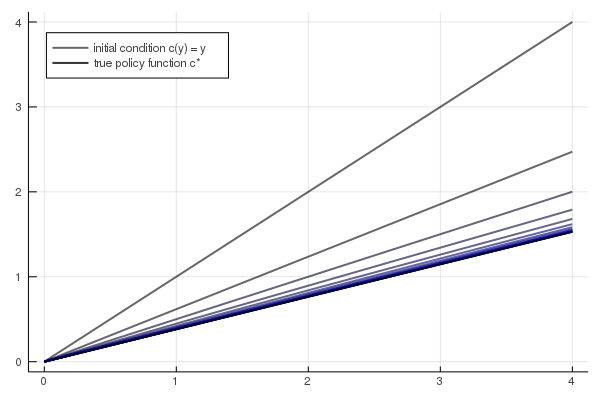

In [13]:
check_convergence(mlog, shocks, c_star, identity, n)

Vemos que a política convergiu muito bem, em apenas algumas etapas.

## Velocidade

Agora vamos comparar o tempo do relógio por iteração para o operador Coleman padrão (com grid exógeno) e a versão EGM.

Faremos isso usando o modelo CRRA adotado nos exercícios da [aula de iteração no tempo da equação de Euler](https://julia.quantecon.org/coleman_policy_iter.html).

Aqui está o modelo e algumas funções convenientes.

In [14]:
mcrra = Model(α = 0.65, β = 0.95, γ = 1.5)
u′_inv(c) = c^(-1 / mcrra.γ)

u′_inv (generic function with 1 method)

Aqui está o resultado.

In [15]:
crra_coleman(g, m, shocks) = K(g, m.grid, m.β, m.u′, m.f, m.f′, shocks)
crra_coleman_egm(g, m, shocks) = coleman_egm(g, m.grid, m.β, m.u′,
                                             u′_inv, m.f, m.f′, shocks)
function coleman(m = m, shocks = shocks; sim_length = 20)
    g = m.grid
    for i in 1:sim_length
        g = crra_coleman(g, m, shocks)
    end
    return g
end
function egm(m, g = identity, shocks = shocks; sim_length = 20)
    for i in 1:sim_length
        g = crra_coleman_egm(g, m, shocks)
    end
    return g.(m.grid)
end

egm (generic function with 3 methods)

In [16]:
@benchmark coleman($mcrra)

BenchmarkTools.Trial: 
  memory estimate:  1.03 GiB
  allocs estimate:  615012
  --------------
  minimum time:     8.715 s (1.80% GC)
  median time:      8.715 s (1.80% GC)
  mean time:        8.715 s (1.80% GC)
  maximum time:     8.715 s (1.80% GC)
  --------------
  samples:          1
  evals/sample:     1

In [17]:
@benchmark egm($mcrra)

BenchmarkTools.Trial: 
  memory estimate:  17.90 MiB
  allocs estimate:  72246
  --------------
  minimum time:     170.137 ms (0.00% GC)
  median time:      177.031 ms (1.95% GC)
  mean time:        176.988 ms (1.56% GC)
  maximum time:     181.908 ms (1.98% GC)
  --------------
  samples:          29
  evals/sample:     1

Vemos que a versão EGM é cerca de 30 vezes mais rápida.

Ao mesmo tempo, a ausência de localização da raiz numérica significa que ela também é tipicamente mais precisa em cada etapa.